# Implementation and validation the gl model with exponential phi curve

To validade the gl model variant with physical units, we replicate some experiments from Lima et al. (2021) [1]

[1] Lima, V., Pena, R. F. O., Shimoura, R. O., Kamiji, N. L., Ceballos, C. C., Borges, F. S., Higa, G. S. V., De Pasquale, R., & Roque, A. C. (2021). Modeling and characterizing stochastic neurons based on in vitro voltage-dependent spike probability functions. The European Physical Journal Special Topics 2021 230:14, 230(14), 2963–2972. https://doi.org/10.1140/EPJS/S11734-021-00160-7

In [1]:
import matplotlib.pyplot as plt
import nest
import numpy as np

from pynestml.frontend.pynestml_frontend import generate_nest_target


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Feb 22 2024 10:55:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Neuron parameters
params = {
    'tau_m'   : 10.0,
    't_ref'   : 2.0,
    'C_m'     : 250.0,
    'V_r'     : -65.0,
    'V_reset' : -65.0,
    'a'       : 1.2,
    'b'       : 27.0,
    'V_b'     : -51.3
}

(-0.01, 1.01)

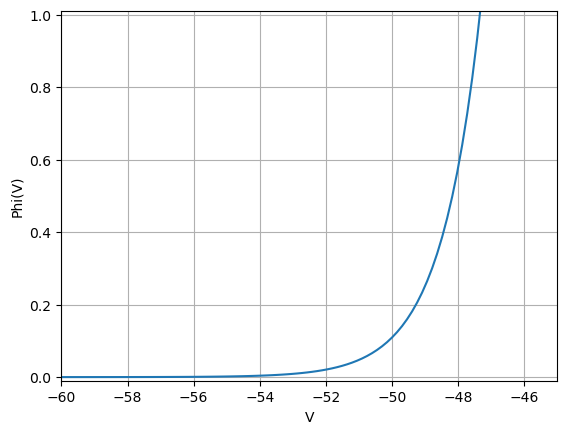

In [3]:
# phi(V) curve
V = np.linspace(-60, -45, 100)

Phi = (1.0/params['b']) * np.exp((V - params['V_b'])/params['a'])

fig, ax = plt.subplots()
ax.plot(V, Phi)
ax.grid(True)
ax.set_xlabel('V')
ax.set_ylabel('Phi(V)')
ax.set_xlim(-60, -45)
ax.set_ylim(-0.01, 1+0.01)

In [4]:
nestml_gl_exp_model = """
neuron gl_exp:
    state:
        refr_spikes_buffer mV = 0 mV
        refr_tick integer = 0    # Counts number of tick during the refractory period
        V_m mV = V_r     # Membrane potential

    equations:
        kernel G = delta(t)
        V_m' = -(V_m - V_r) / tau_m + (mV / ms) * convolve(G, spikes) + (I_e + I_stim) / C_m

    parameters:
        tau_m   ms   = 10 ms              # Membrane time constant
        C_m     pF   = 250 pF             # Capacity of the membrane
        t_ref   ms   = 2 ms               # Duration of refractory period
        tau_syn ms   = 0.5 ms             # Time constant of synaptic current
        V_r     mV   = -65 mV             # Resting membrane potential
        V_reset mV   = -65 mV             # Reset potential of the membrane
        b     real   = 27                 # Parameter for the exponential curve
        a       mV   = 5 mV               # Parameter for the exponential curve
        V_b mV       = -51.3 mV             # Membrane potential at which phi(V)=1/b
        with_refr_input boolean = false # If true, do not discard input during refractory period.

        # constant external input current
        I_e pA = 0 pA

    internals:
        h ms = resolution()
        RefractoryCounts integer = steps(t_ref) # refractory time in steps

    input:
        spikes <- spike
        I_stim pA <- continuous

    output:
        spike

    function phi(V_m mV) real:
        return ((1/b) * exp((V_m - V_b)/a))

    update:
        if refr_tick == 0: # neuron not refractory
            integrate_odes()

            # if we have accumulated spikes from refractory period,
            # add and reset accumulator
            if with_refr_input and refr_spikes_buffer != 0.0 mV:
                V_m += refr_spikes_buffer
                refr_spikes_buffer = 0.0 mV

        else: # neuron is absolute refractory
            # read spikes from buffer and accumulate them, discounting
            # for decay until end of refractory period
            # the buffer is clear automatically
            if with_refr_input:
                refr_spikes_buffer += spikes * exp(-refr_tick * h / tau_m) * mV * s
            refr_tick -= 1

        if random_uniform(0, 1) <= h*phi(V_m):
            # tmp real = phi(V_m)
            # println("{tmp}")
            refr_tick = RefractoryCounts
            V_m = V_reset
            emit_spike()
"""

In [5]:
with open("nestml_gl_exp_model.nestml", "w") as nestml_model_file:
    print(nestml_gl_exp_model, file=nestml_model_file)

generate_nest_target(input_path="nestml_gl_exp_model.nestml",
                     target_path="/tmp/nestml-gl-target",
                     module_name="nestml_gl_exp_module",
                     suffix="_nestml",
                     logging_level="INFO"  # try "INFO" for more debug information
                    )

nest.Install("nestml_gl_exp_module")

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /Users/pooja/nestml/master/doc/tutorials/gl_model/nestml_gl_exp_model.nestml
[3,GLOBAL, INFO]: Target platform code will be generated in directory: '/tmp/nestml-gl-target'

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Feb 22 2024 10:55:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[4,GLOBAL, INFO]: The NEST Simulator version was automatically detected as: v3.6.0
[5,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/Users/pooja/.local/lib/python3.11/site-packages/NESTML-7.0.0.post0.dev0-py3.11.egg/pynestml/codegeneration/resources_nest/point_neuron'
[6,GLOBAL, INFO]: Given template root path is not an absolute path. Creatin

INFO:root:Analysing input:
INFO:root:{
    "dynamics": [
        {
            "expression": "V_m' = (-(V_m - V_r)) / tau_m + (1.0 / 1.0) * 0 + (I_e + I_stim) / C_m",
            "initial_values": {
                "V_m": "V_r"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "I_e": "0",
        "V_b": "(-51.3)",
        "V_r": "(-65)",
        "V_reset": "(-65)",
        "a": "5",
        "b": "27",
        "t_ref": "2",
        "tau_m": "10",
        "tau_syn": "0.5",
        "with_refr_input": "false"
    }
}
INFO:root:Processing global options...
INFO:root:Processing input shapes...
INFO:root:
Processing differential-equation form shape V_m with defining expression = "(-(V_m - V_r)) / tau_m + (1.0 / 1.0) * 0 + (I_e + I_stim) / C_m"
INFO:root:	Returning shape: Shape "V_m" of order 1
INFO:root:Shape V_m: reconstituting expression -V_m/tau_m + V_r/tau_m + I_e/C_m + I_stim/C_m
INFO:root:All 

[22,gl_exp_nestml, INFO, [19:23;19:23]]: Implicit casting from (compatible) type 'integer' to 'real'.
[23,GLOBAL, INFO]: Analysing/transforming neuron 'gl_exp_nestml'
[24,gl_exp_nestml, INFO, [2:0;64:0]]: Starts processing of the model 'gl_exp_nestml'


INFO:root:update_expr[V_m] = V_m*__P__V_m__V_m - V_r*__P__V_m__V_m + V_r - I_e*__P__V_m__V_m*tau_m/C_m + I_e*tau_m/C_m - I_stim*__P__V_m__V_m*tau_m/C_m + I_stim*tau_m/C_m
INFO:root:In ode-toolbox: returning outdict = 
INFO:root:[
    {
        "initial_values": {
            "V_m": "V_r"
        },
        "parameters": {
            "C_m": "250.000000000000",
            "I_e": "0",
            "V_r": "-65.0000000000000",
            "tau_m": "10.0000000000000"
        },
        "propagators": {
            "__P__V_m__V_m": "exp(-__h/tau_m)"
        },
        "solver": "analytical",
        "state_variables": [
            "V_m"
        ],
        "update_expressions": {
            "V_m": "V_m*__P__V_m__V_m - V_r*__P__V_m__V_m + V_r - I_e*__P__V_m__V_m*tau_m/C_m + I_e*tau_m/C_m - I_stim*__P__V_m__V_m*tau_m/C_m + I_stim*tau_m/C_m"
        }
    }
]


ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
[26,gl_exp_nestml, WARNING, [20:8;20:25]]: Variable 'a' has the same name as a physical unit!
[27,gl_exp_nestml, WARNING, [28:8;28:26]]: Variable 'h' has the same name as a physical unit!
[28,gl_exp_nestml, INFO, [19:23;19:23]]: Implicit casting from (compatible) type 'integer' to 'real'.
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code versions disagree: 4.13.0!=4.10.1
ANTLR runtime and generated code version

## Computing reliability of the single neuron model

In [6]:
def evaluate_neuron(neuron_name, nneurons=1, neuron_parms=None, stimulus_type="constant", poisson_fr=0.0,
                    mu=500., sigma=0., t_sim=300., plot=False, rseed=1000, dt=0.1, input_freq=0.0):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    nest.ResetKernel()
    nest.SetKernelStatus({'rng_seed': rseed,
                          'resolution': dt})
    neuron = nest.Create(neuron_name, nneurons)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    nest.SetStatus(neuron,{'V_m':np.random.uniform(-65.0, -50.0)})
    nest.SetStatus(neuron, "I_e", mu)

    if stimulus_type == "noise":
        # Create a noise generator
        noise = nest.Create("noise_generator")
        # Set the parameters of the noise generator
        noise_params = {"mean": mu, 
                        "std": sigma, 
                        "dt": dt,
                        "frequency":input_freq}
        nest.SetStatus(noise, noise_params)
        nest.Connect(noise, neuron)

    elif stimulus_type == "poisson_spikes":
        # Create a Poisson generator device
        poisson = nest.Create("poisson_generator", params={"rate": poisson_fr})

        # Create a parrot neuron
        parrot = nest.Create("parrot_neuron")

        # Connect the Poisson generator to the parrot neuron
        nest.Connect(poisson, parrot)

        # Connect the parrot neuron to each neuron
        nest.Connect(parrot, neuron)
    else:
        raise Exception("Unknown stimulus type: " + str(stimulus_type))

    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    spike_recorder = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)

    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
                        
    dSD = nest.GetStatus(spike_recorder, keys='events')[0]
    ns = dSD['senders']
    ts = dSD["times"]

    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()

    return ts, ns

### Constant input current


Feb 26 10:50:14 gl_exp_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 10:50:14 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 26 10:50:14 NodeManager::prepare_nodes [Info]: 
    Preparing 54 nodes for simulation.

Feb 26 10:50:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 54
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Feb 26 10:50:14 SimulationManager::run [Info]: 
    Simulation finished.

Feb 26 10:50:14 gl_exp_nestml [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Feb 26 10:50:14 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 26 10:50:14 NodeManager::prepare_nodes [Info]: 
    Preparing 54 nodes for simulation.

Feb 26 10:50:14 SimulationManager::start_updating_ [Info]: 


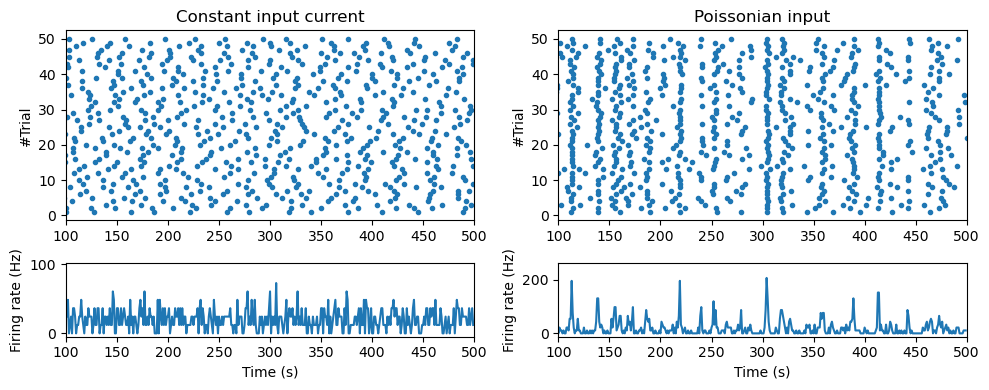

In [7]:
dt = 0.1
nneurons = 50

ts_const, ns_const = evaluate_neuron('gl_exp_nestml', nneurons=nneurons, neuron_parms=params, stimulus_type='poisson_spikes',\
                          mu=400., t_sim=500.0, dt=dt, poisson_fr = 0.0)

ts_noise, ns_noise = evaluate_neuron('gl_exp_nestml', nneurons=nneurons, neuron_parms=params, stimulus_type='poisson_spikes',\
                          mu=150., t_sim=500.0, dt=dt, poisson_fr = 1000.0)

# PSTH parameters
t_start = 0.0
t_stop  = 500.0
t_step  = 1.0
t_bins = np.arange(t_start, t_stop + t_step, t_step)

# Calculate the PSTH
psth_const, _ = np.histogram(ts_const, bins=t_bins)
psth_const = psth_const / len(ts_const) / (dt*1e-3)  # divide by number of trials and time bin size

psth_noise, _ = np.histogram(ts_noise, bins=t_bins)
psth_noise = psth_noise / len(ts_noise) / (dt*1e-3)  # divide by number of trials and time bin size

plt.figure(figsize=(10,4))
# Raster plot
plt.subplot2grid((3,2),(0,0), rowspan=2)
plt.plot(ts_const, ns_const, '.')
plt.xlim(100, 500)
plt.ylabel('#Trial')
plt.title('Constant input current')

plt.subplot2grid((3,2),(0,1), rowspan=2)
plt.plot(ts_noise, ns_noise, '.')
plt.xlim(100, 500)
plt.ylabel('#Trial')
plt.title('Poissonian input')

# Plot the PSTH
plt.subplot2grid((3,2),(2,0), rowspan=1)
plt.plot(t_bins[:-1], psth_const)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(100, 500)

plt.subplot2grid((3,2),(2,1), rowspan=1)
plt.plot(t_bins[:-1], psth_noise)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(100, 500)
plt.tight_layout()

In [8]:
len(ts_const)/0.5/50

34.32

In [9]:
len(ts_noise)/0.5/50

36.72